## Beam deflection with double integration

In [1]:
%matplotlib notebook
from bmcs_utils.api import InteractiveModel, IPWInteract 
import traits.api as tr
import matplotlib.pylab as plt
import numpy as np
import sympy as sp

In [2]:
x, M, L , P= sp.symbols('x, M, L, P')
# data = { M : P*L/4}
PtoM = { P : M*4/L}
# M_ = 2*M/L - 4*M/L*(x-L/2)
M_ = sp.Piecewise((2*M*x/L, x <= L/2),
             ((2*M*x/L - (4*M/L)*(x-L/2)), x>L/2)
            )
M_

Piecewise((2*M*x/L, x <= L/2), (2*M*x/L - 4*M*(-L/2 + x)/L, True))

In [3]:
get_M = sp.lambdify((x,M,L), M_)

In [4]:
# theta_ = sp.integrate(M_,x)
theta_ = sp.Piecewise((M*x**2/L - P*L**2/16, x <= L/2),
    (P*x**2/4 - P*L**2/16 - P/2*(x-L/2)**2, x > L/2))
         
theta_

Piecewise((-L**2*P/16 + M*x**2/L, x <= L/2), (-L**2*P/16 + P*x**2/4 - P*(-L/2 + x)**2/2, True))

In [5]:
theta_ = theta_.subs(PtoM)
theta_

Piecewise((-L*M/4 + M*x**2/L, x <= L/2), (-L*M/4 + M*x**2/L - 2*M*(-L/2 + x)**2/L, True))

In [6]:
get_theta = sp.lambdify((x,M,L), theta_)

In [7]:
Delta_ = sp.integrate(theta_,x)
Delta_

Piecewise((-L*M*x/4 + M*x**3/(3*L), x <= L/2), (L**2*M/12 - 3*L*M*x/4 + M*x**2 - M*x**3/(3*L), True))

In [8]:
get_Delta = sp.lambdify((x,M,L), Delta_)

In [9]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [10]:
class Beam3PtBending(InteractiveModel):
    
    name = 'Inputs'
    
    L = tr.Float(100, param=True, latex='L [cm]', minmax=(100,1000))
    H = tr.Float(10, param=True, latex='H [cm]', minmax=(10,100))
    B = tr.Float(10, param=True, latex='B [cm]', minmax=(10,100))
    E = tr.Float(1, param=True, latex='E [N/cm2]', minmax=(1,100))
    F = tr.Float(10, param=True, latex='F [N]', minmax=(10,1000))
    n_x = tr.Float(1000, param=True, latex='n_x', minmax=(1,1000))

    
    param_names = ['L', 'H', 'B', 'E' ,'F']

    def get_M_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2/1000 * self.L / 2
        M_x = get_M(x,M,self.L)
        return x, M_x
    
    def get_Th_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2 * self.L / 2
        Th_x = get_theta(x,M,self.L) 
        I = (self.B*self.H**3)/12
        Th_x = Th_x / (self.E*I)
        return x, Th_x
    
    def get_D_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2 * self.L / 2
        D_x = get_Delta(x,M,self.L)
        I = (self.B*self.H**3)/12
        D_x = D_x / (self.E*I)
        return x, D_x
      
    def get_phi_x(self):
        x, M_x = self.get_M_x()
        phi_x = np.trapz(M_x, x)
        return phi_x
    
    def subplots(self, fig):
        return fig.subplots(4, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3, ax4 = axes
        
#         ax1.axis('equal');
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax1.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        x, M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [kN.cm]')
        leg = ax2.legend();

        x, Th_x = self.get_Th_x()
        ax3.plot(x, Th_x, color='green', label='theta []')
        leg = ax3.legend();
        
        x, D_x = self.get_D_x()
        ax4.plot(x, D_x, color='blue', label='w [cm]')
        leg = ax4.legend();

<IPython.core.display.Javascript object>


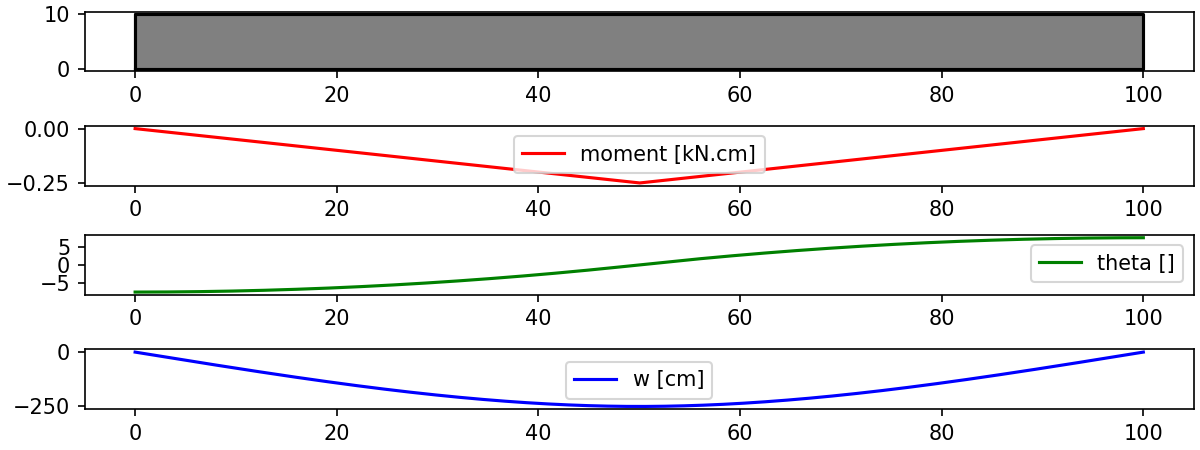

In [11]:
bd = Beam3PtBending()
ibd = IPWInteract(bd)
ibd.interact()